<h1> Imports </h1>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as seaborn

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

<h1> Dataset analysis and exploration (first look) </h1>

Description of attributes (first intuition):
- Price: the monetary value associated with the property or real estate.
- Area: the total area of the property, usually measured in square units (e.g., square feet or square meters).
- Bedrooms: the number of bedrooms in the property, indicating the available sleeping spaces.
- Bathrooms: the number of bathrooms in the property, indicating the available bathing spaces.
- Stories: the number of floors or levels in the property, representing its vertical structure.
- Mainroad: a binary indicator (yes/no or 1/0) that may represent whether the property is located near a main road.
- Guestroom: a binary indicator that may represent whether the property has a guest room.
- Basement: a binary indicator that may represent whether the property has a basement.
- Hotwaterheating: a binary indicator that may represent whether hot water heating is available in the property.
- Airconditioning: a binary indicator that may represent whether the property is equipped with air conditioning.
- Parking: the availability (amount) of parking spaces associated with the property.
- Prefarea: a binary indicator that may represent whether the property is located in a preferred or desirable area.
- Furnishingstatus: the status or level of furnishing in the property, indicating whether it is furnished, semi-furnished, or unfurnished.

In [3]:
# Import dataset

dataset_raw = pd.read_csv("Housing.csv")
dataset_raw.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
6,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished


In [4]:
print("Columns: ")
for column in dataset_raw.columns:
    print("- " + column)

Columns: 
- price
- area
- bedrooms
- bathrooms
- stories
- mainroad
- guestroom
- basement
- hotwaterheating
- airconditioning
- parking
- prefarea
- furnishingstatus


Variables available:
- Target(Y): price
- Attributes (X): rest 

In [5]:
dataset_raw.shape

(545, 13)

In [6]:
dataset_raw.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


Goal: predict price based on the rest of attributes

<h1> Data preprocessing: handle missing and invalid and duplicated samples </h1>

In [7]:
dataset_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [8]:
from datetime import datetime

is_number = lambda value_in: isinstance(value_in, (int, float))
is_int = lambda value_in: isinstance(value_in, int)
is_natural = lambda value_in: is_int(value_in) and value_in >= 0
is_positive_int = lambda value_in: is_int(value_in) and value_in > 0
is_positive_float = lambda value_in: isinstance(value_in, float) and value_in > 0
is_boolean = lambda value_in: isinstance(value_in, bool)
is_percent = lambda value_in: (is_number(value_in) and value_in >= 0 and value_in <= 100)
def is_valid_date(year, month, day):
    try:
        datetime(year, month, day)
        return True
    except ValueError:
        return False
is_string = lambda value_in: isinstance(value_in, str)
is_not_empty_string = lambda value_in: is_string(value_in) and len(value_in) > 0   
def convert_string_to_number(s):
    try:
        number = float(s.replace(",", ""))
        if number.is_integer():
            return int(number)
        else:
            return number
    except ValueError:
        return None
def is_string_natural(value_in):
    temp_value = None
    if is_string(value_in):
        temp_value = convert_string_to_number(value_in)        
    return True if (temp_value is not None and is_natural(temp_value)) else False


is_valid_price = lambda price: is_positive_float(price) or is_positive_int(price)
is_valid_area = lambda area: is_positive_float(area) or is_positive_int(area)
is_valid_bedrooms = lambda bedrooms: is_natural(bedrooms)
is_valid_bathrooms = lambda bathrooms: is_natural(bathrooms)
is_valid_stories = lambda stories: is_positive_int(stories)
is_valid_mainroad = lambda mainroad: is_boolean(mainroad)
is_valid_guestroom = lambda guestroom: is_boolean(guestroom)
is_valid_basement = lambda basement: is_boolean(basement)
is_valid_hotwaterheating = lambda hotwaterheating: is_boolean(hotwaterheating)
is_valid_airconditioning = lambda airconditioning: is_boolean(airconditioning)
is_valid_parking = lambda parking: is_natural(parking)
is_valid_prefarea = lambda prefarea: is_boolean(prefarea)
is_valid_furnishingstatus = lambda furnishingstatus: furnishingstatus in ["furnished", "semi-furnished", "unfurnished"]

def add_bad_param(invalid_params_dict, attribute, sample):
    ext_key = attribute
    int_key = sample[attribute]
    if not ext_key in invalid_params_dict.keys():
        invalid_params_dict[ext_key] = {}
    if not int_key in invalid_params_dict[ext_key]:
        invalid_params_dict[ext_key][int_key] = 0
    invalid_params_dict[ext_key][int_key] += 1

def is_valid_sample(sample, invalid_params_dict):
    if not is_valid_price(sample['price']):                         add_bad_param(invalid_params_dict, 'price', sample)
    if not is_valid_area(sample['area']):                           add_bad_param(invalid_params_dict, 'area', sample)
    if not is_valid_bedrooms(sample['bedrooms']):                   add_bad_param(invalid_params_dict, 'bedrooms', sample)
    if not is_valid_bathrooms(sample['bathrooms']):                 add_bad_param(invalid_params_dict, 'bathrooms', sample)
    if not is_valid_stories(sample['stories']):                     add_bad_param(invalid_params_dict, 'stories', sample)
    if not is_valid_mainroad(sample['mainroad']):                   add_bad_param(invalid_params_dict, 'mainroad', sample)
    if not is_valid_guestroom(sample['guestroom']):                 add_bad_param(invalid_params_dict, 'guestroom', sample)
    if not is_valid_basement(sample['basement']):                   add_bad_param(invalid_params_dict, 'basement', sample)
    if not is_valid_hotwaterheating(sample['hotwaterheating']):     add_bad_param(invalid_params_dict, 'hotwaterheating', sample)
    if not is_valid_airconditioning(sample['airconditioning']):     add_bad_param(invalid_params_dict, 'airconditioning', sample)
    if not is_valid_parking(sample['parking']):                     add_bad_param(invalid_params_dict, 'parking', sample)
    if not is_valid_prefarea(sample['prefarea']):                   add_bad_param(invalid_params_dict, 'prefarea', sample)
    if not is_valid_furnishingstatus(sample['furnishingstatus']):   add_bad_param(invalid_params_dict, 'furnishingstatus', sample)

def print_invalid_params_formatted_df(invalid_params_dict):  
    invalid_params_formatted_dict = {}
    invalid_params_formatted_dict['attribute'] = []
    invalid_params_formatted_dict['invalid_value'] = []
    invalid_params_formatted_dict['count'] = []
    for ext_key in invalid_params_dict.keys():
        for int_key in invalid_params_dict[ext_key]:
            invalid_params_formatted_dict['attribute'].append(ext_key)
            invalid_params_formatted_dict['invalid_value'].append(int_key)
            invalid_params_formatted_dict['count'].append(invalid_params_dict[ext_key][int_key])        
    invalid_params_formatted_df = pd.DataFrame(invalid_params_formatted_dict)
    display(invalid_params_formatted_df)

def check_dataset(dataset_raw):
    
    invalid_params_dict = {}    # Each key corresponds to an attribute which contains at least an invalid value.
                                # For each key, the value is another dictionary where each key is a found invalid value and the value is the number of repetitions

    # Iterate all samples and, for each sample, check each of its attributes
    for iter, sample in dataset_raw.iterrows():
        is_valid_sample(sample, invalid_params_dict)
        
    print_invalid_params_formatted_df(invalid_params_dict)


In [9]:
# Look for missing (NaN or None) values
dataset_raw.isna().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [10]:
check_dataset(dataset_raw)

,attribute,invalid_value,count
0,mainroad,yes,468
1,mainroad,no,77
2,guestroom,no,448
3,guestroom,yes,97
4,basement,no,354
5,basement,yes,191
6,hotwaterheating,no,520
7,hotwaterheating,yes,25
8,airconditioning,yes,172
9,airconditioning,no,373


In [11]:
dataset_cleaned = dataset_raw.copy()
# Handle yes/no values in mainroad, guestroom, basement, hotwaterheating, airconditioning and prefarea
dataset_cleaned['mainroad'] = dataset_cleaned['mainroad'].apply(lambda value: False if value == 'no' else True if value == 'yes' else None)
dataset_cleaned['guestroom'] = dataset_cleaned['guestroom'].apply(lambda value: False if value == 'no' else True if value == 'yes' else None)
dataset_cleaned['basement'] = dataset_cleaned['basement'].apply(lambda value: False if value == 'no' else True if value == 'yes' else None)
dataset_cleaned['hotwaterheating'] = dataset_cleaned['hotwaterheating'].apply(lambda value: False if value == 'no' else True if value == 'yes' else None)
dataset_cleaned['airconditioning'] = dataset_cleaned['airconditioning'].apply(lambda value: False if value == 'no' else True if value == 'yes' else None)
dataset_cleaned['prefarea'] = dataset_cleaned['prefarea'].apply(lambda value: False if value == 'no' else True if value == 'yes' else None)

# Check dataset after cleaning
check_dataset(dataset_cleaned)

,attribute,invalid_value,count


In [12]:
# Remove duplicates samples
   
dataset_cleaned.loc[dataset_cleaned.duplicated()]

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus


No duplicated sample found

<h1> Data preprocessing: outliers </h1>

In [13]:
dataset_cleaned.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [14]:
from scipy import stats

def get_outliers_zscore(attribute, threshold=3):
    z_scores = stats.zscore(attribute)
    outliers = attribute[abs(z_scores) > threshold]
    return outliers

def get_outliers_interquartile(data, factor=1.5):
    """
    Identify potential outliers in a numerical dataset using the IQR method.

    Parameters:
    - data: Pandas Series or DataFrame column
    - factor: Multiplier for the IQR (default is 1.5)

    Returns:
    - List of potential outlier indices
    """
    # Ensure data is numeric
    data = pd.to_numeric(data, errors='coerce')

    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr

    outliers = data[(data < lower_bound) | (data > upper_bound)]

    return outliers.index.tolist()


numerical_attributes = list()
numerical_attributes.append('price')
numerical_attributes.append('area')
numerical_attributes.append('bedrooms')
numerical_attributes.append('bathrooms')
numerical_attributes.append('stories')
numerical_attributes.append('parking')

for attribute in numerical_attributes:
    outliers = get_outliers_interquartile(dataset_cleaned[attribute], 1.5) 
    print(f'Attribute {attribute}: {len(outliers)} potential outliers found')
    


Attribute price: 15 potential outliers found
Attribute area: 12 potential outliers found
Attribute bedrooms: 12 potential outliers found
Attribute bathrooms: 1 potential outliers found
Attribute stories: 41 potential outliers found
Attribute parking: 12 potential outliers found


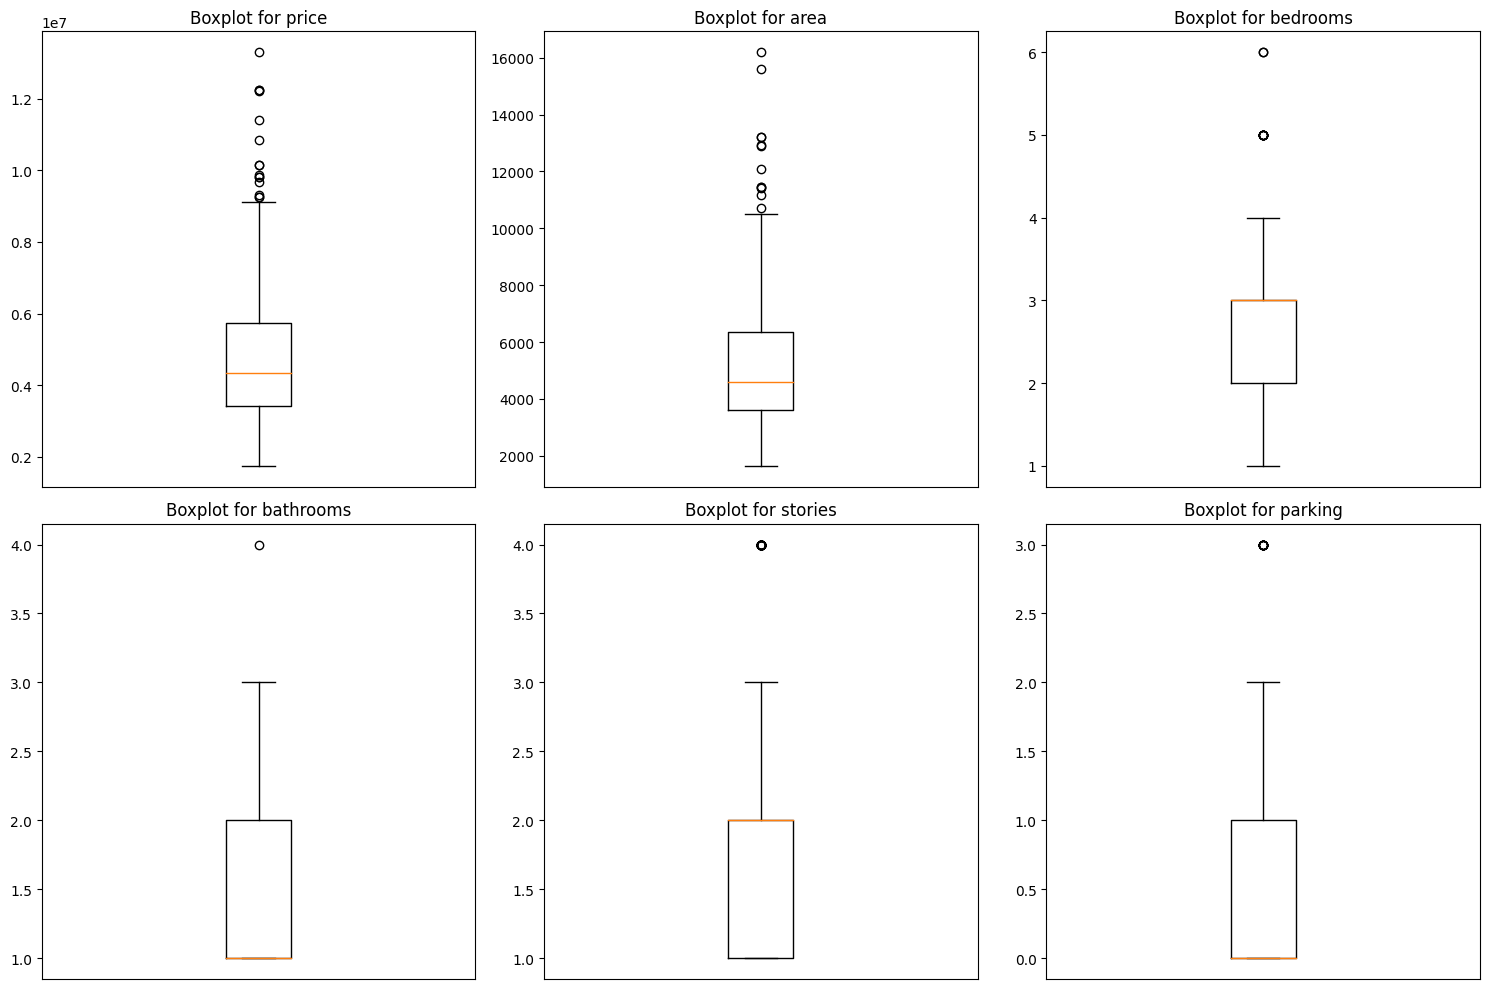

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Iterate through each attribute and create a boxplot
for i, attribute in enumerate(numerical_attributes):
    axes[i].boxplot(dataset_cleaned[attribute])
    axes[i].set_title(f'Boxplot for {attribute}')

# Labeling the x-axis
for ax in axes:
    ax.set_xticks([])  # Remove x-axis ticks for better readability

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


No outlier is removed (no one looks critical)

<h1> Visualise data </h1>

<h2> Categorical attributes </h2>

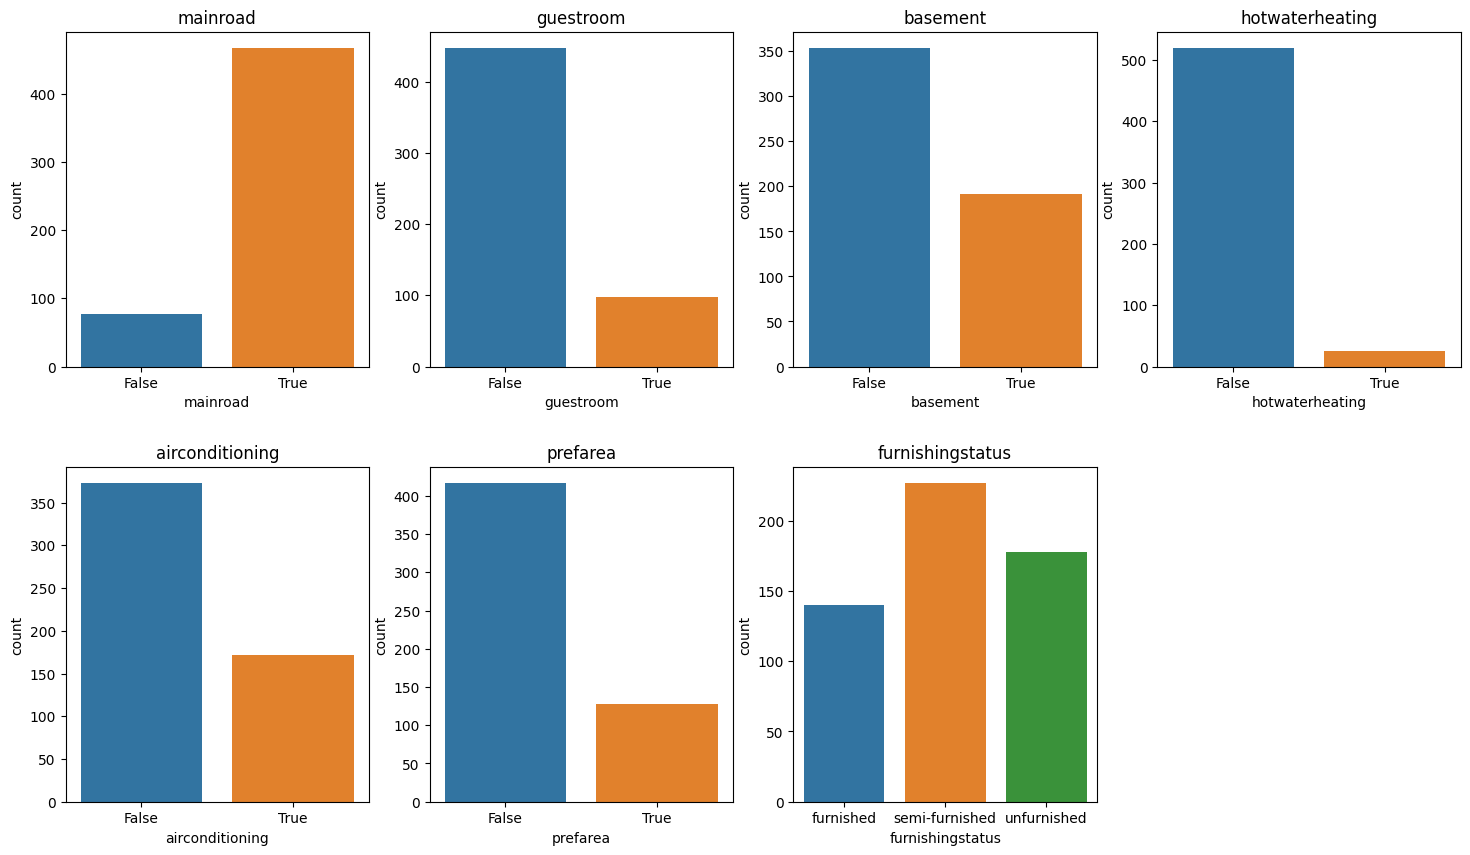

In [16]:
# Frequency distribution of each categorical attribute

attributes_categorical = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

selected_columns = dataset_cleaned[attributes_categorical]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))
fig.subplots_adjust(hspace=0.3)  # Adjust the vertical spacing between subplots

# Flatten the 2x4 grid to iterate over subplots
axes = axes.flatten()

# Plot bar plots for each attribute
for i, attribute in enumerate(attributes_categorical):
    ax = axes[i]
    seaborn.countplot(data=selected_columns, x=attribute, ax=ax)
    ax.set_title(attribute)

# Remove the last subplot (bottom-right)
fig.delaxes(axes[-1])

# Show the plot
plt.show()


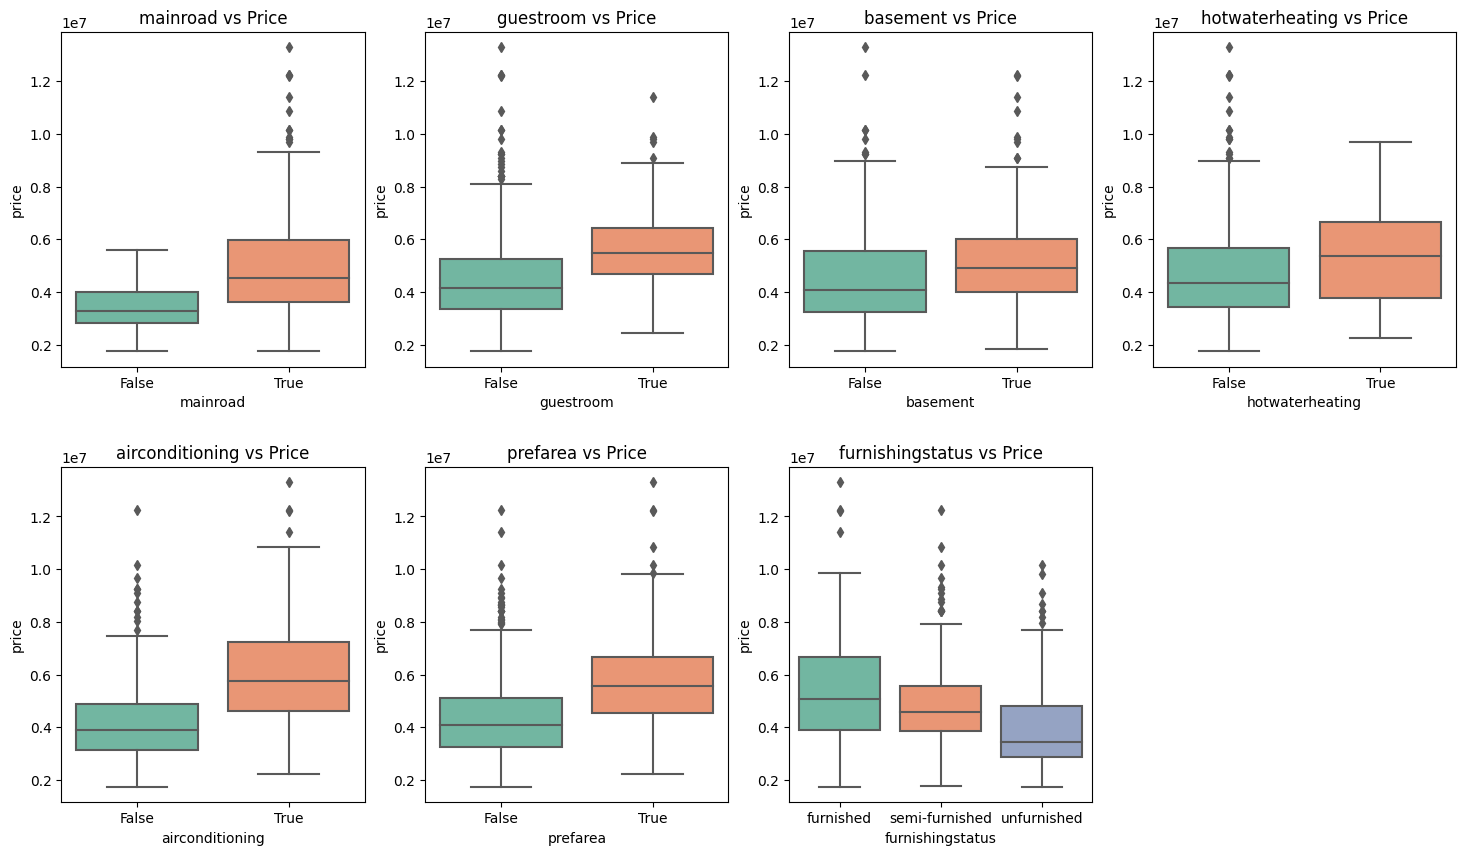

In [17]:
# Plot categorical attributes vs target

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))
fig.subplots_adjust(hspace=0.3)  # Adjust the vertical spacing between subplots

# Flatten the 2x4 grid to iterate over subplots
axes = axes.flatten()

# Plot boxplots for each categorical attribute vs price
for i, attribute in enumerate(attributes_categorical):
    ax = axes[i]
    seaborn.boxplot(x=dataset_cleaned[attribute], y=dataset_cleaned['price'], palette="Set2", ax=ax)
    ax.set_title(f'{attribute} vs Price')

fig.delaxes(axes[-1]) # Remove the last subplot (bottom-right)
plt.show()


<h2> Numerical attributes </h2>

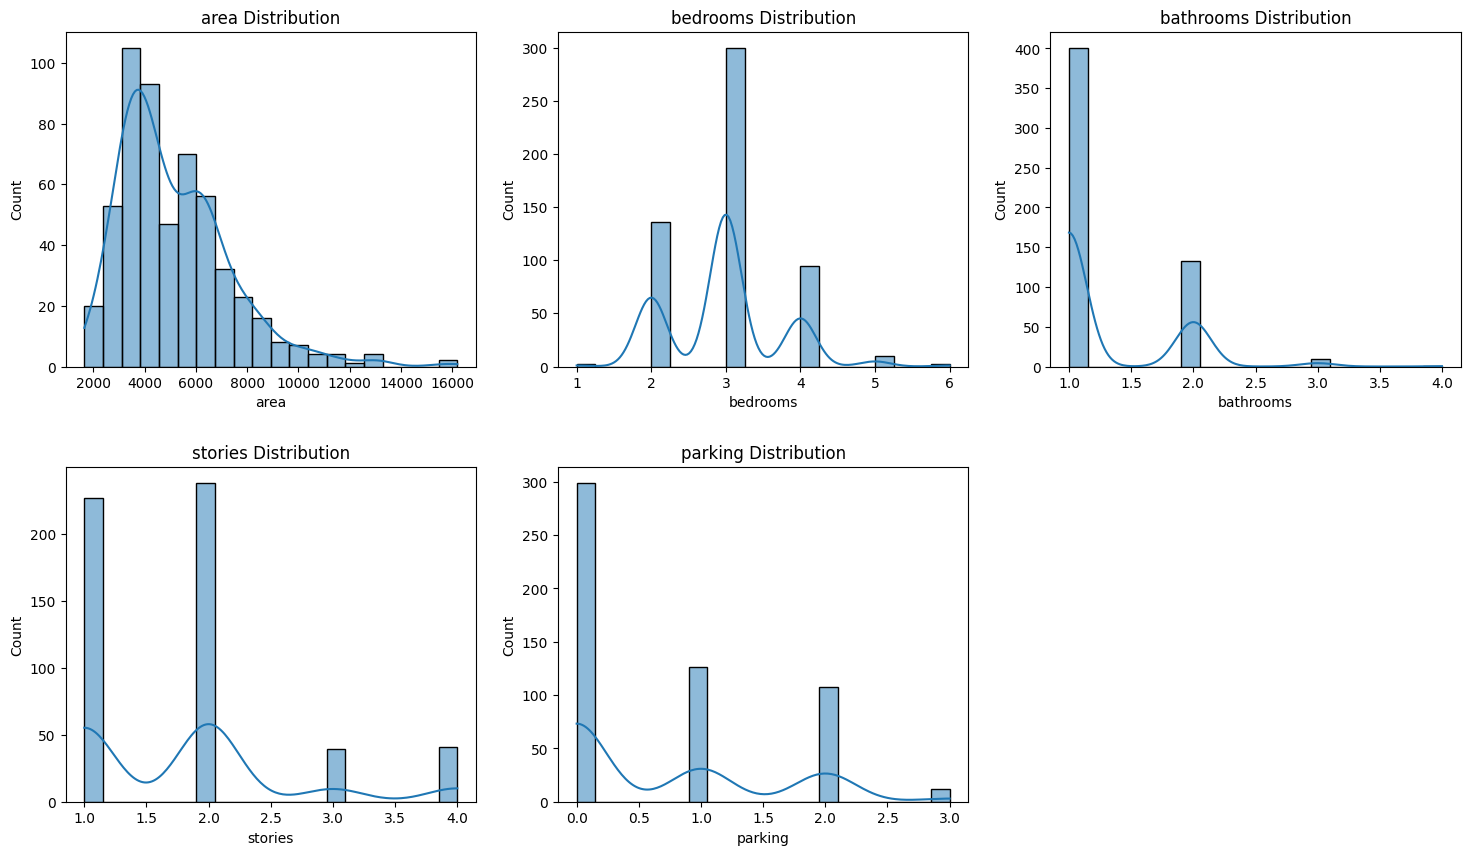

In [18]:
# Frequency distribution of each categorical attribute

numerical_attributes = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.subplots_adjust(hspace=0.3)  # Adjust the vertical spacing between subplots
axes = axes.flatten() # Flatten the 2x3 grid to iterate over subplots

# Plot histograms for each numerical attribute
for i, attribute in enumerate(numerical_attributes):
    ax = axes[i]
    seaborn.histplot(dataset_cleaned[attribute], ax=ax, bins=20, kde=True)
    ax.set_title(f'{attribute} Distribution')

fig.delaxes(axes[-1]) # Remove the last subplot (bottom-right)
plt.show()

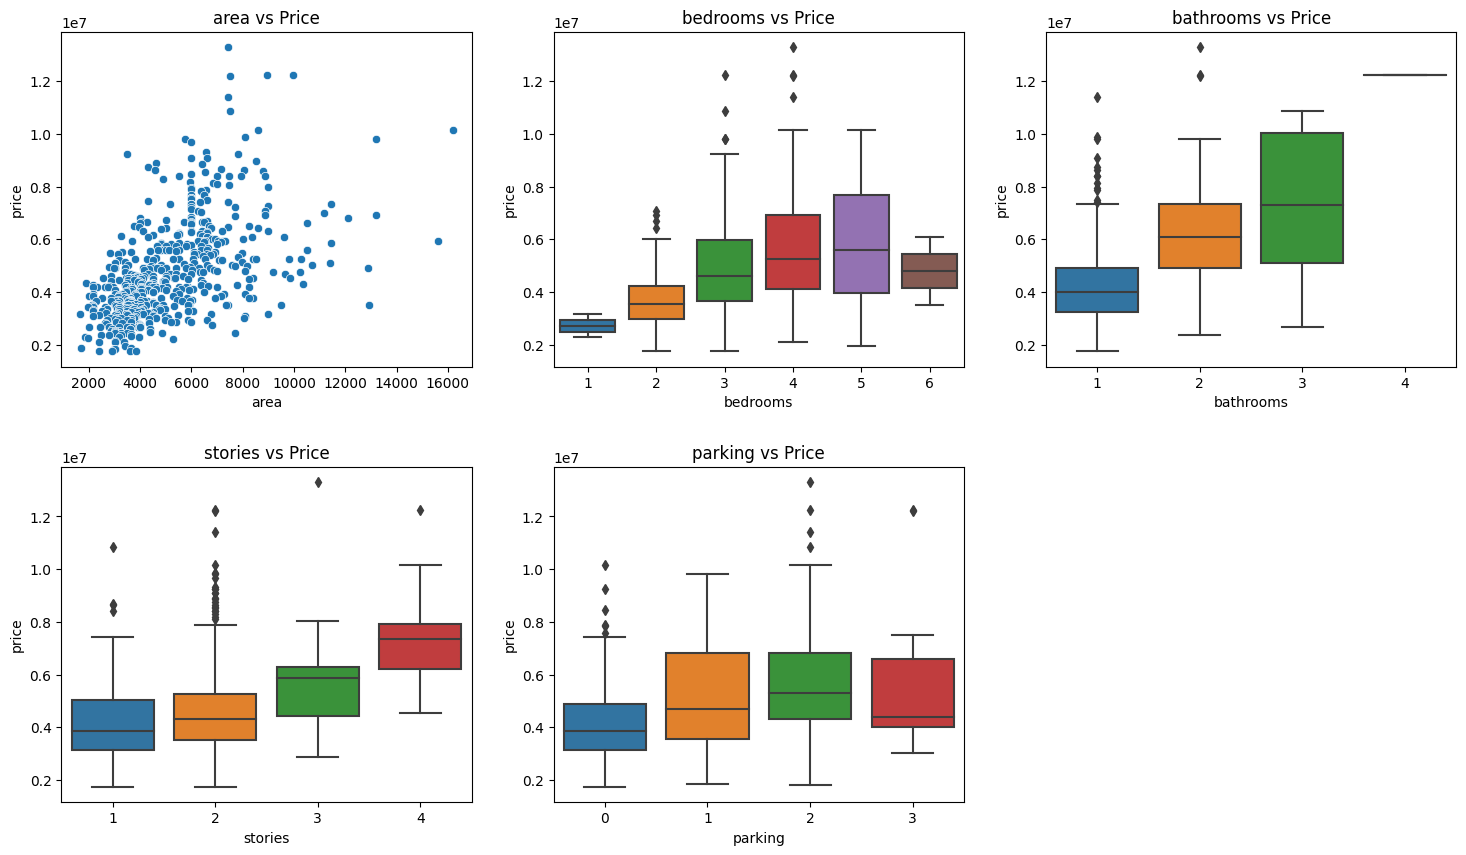

In [19]:
# Plot categorical attributes vs target

numerical_attributes = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.subplots_adjust(hspace=0.3)  # Adjust the vertical spacing between subplots
axes = axes.flatten() # Flatten the 2x3 grid to iterate over subplots

# Plot boxplots for each numerical attribute vs. price

for i, attribute in enumerate(numerical_attributes):
    ax = axes[i]
    if attribute == 'area':
        seaborn.scatterplot(x=dataset_cleaned['area'], y=dataset_cleaned['price'], ax=ax)
    else:
        seaborn.boxplot(x=dataset_cleaned[attribute], y=dataset_cleaned['price'], ax=ax)
    ax.set_title(f'{attribute} vs Price')

fig.delaxes(axes[-1]) # Remove the last subplot (bottom-right)
plt.show()


<h2> Correlation matrix </h2>

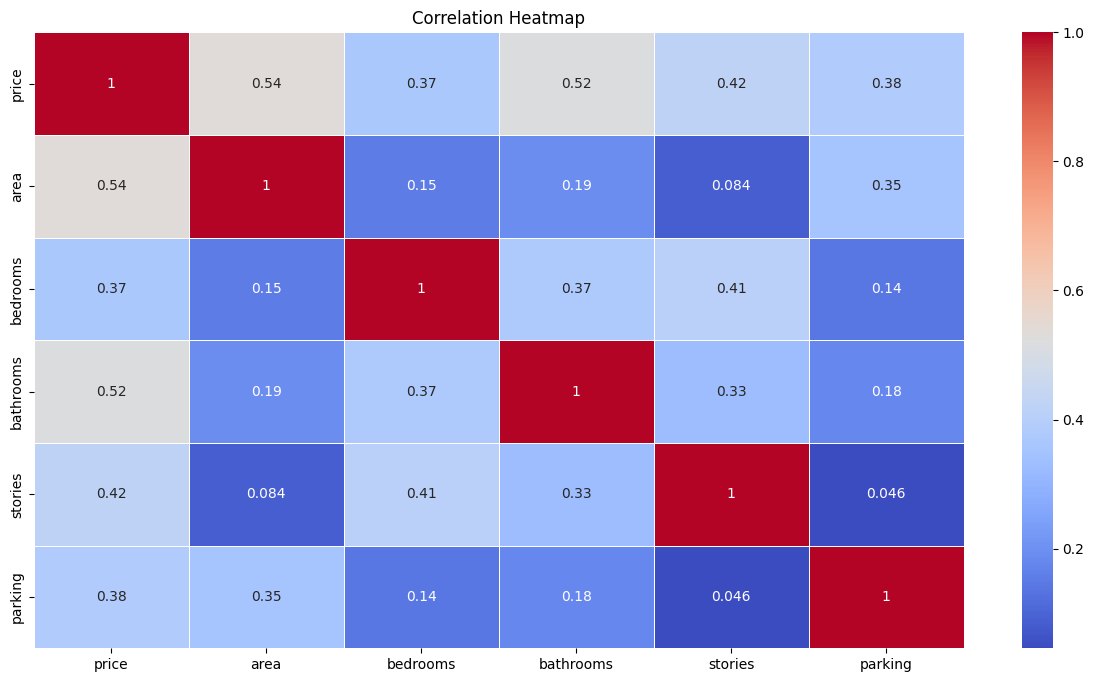

In [20]:
X_numerical = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
y = ['price']
numerical_data = pd.DataFrame(dataset_cleaned[y + X_numerical])

correlation_matrix = numerical_data.corr()
plt.figure(figsize=(15, 8))  # Set the figure size
seaborn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Conclusions on correlation
- Most significant attributes are area and bathrooms

<h1> Data preprocessing: dummy variables </h1>

In [21]:
dummies_list = ['mainroad', 'guestroom', 'hotwaterheating', 'basement', 'airconditioning', 'prefarea', 'furnishingstatus']
for dummy_var in dummies_list:
    dummy_temp = pd.get_dummies(dataset_cleaned[dummy_var], prefix=dummy_var, drop_first=True).astype(int)
    dataset_cleaned = pd.concat([dataset_cleaned, dummy_temp], axis=1)
    dataset_cleaned.drop([dummy_var], axis=1, inplace=True)
    
dataset_cleaned

,price,area,bedrooms,bathrooms,stories,parking,mainroad_True,guestroom_True,hotwaterheating_True,basement_True,airconditioning_True,prefarea_True,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,2,1,0,0,0,1,1,0,0
1,12250000,8960,4,4,4,3,1,0,0,0,1,0,0,0
2,12250000,9960,3,2,2,2,1,0,0,1,0,1,1,0
3,12215000,7500,4,2,2,3,1,0,0,1,1,1,0,0
4,11410000,7420,4,1,2,2,1,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,2,1,0,0,1,0,0,0,1
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,1,0
542,1750000,3620,2,1,1,0,1,0,0,0,0,0,0,1
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,0,0


<h1> Data preprocessing: analyse and reduce dimensionality </h1>

Correlation across attributes (by looking at correlation matrix):
- The most significant correlation is between bedrooms and stories (0.41)

<h2> PCA </h2>


Individual variance explained: [1.92945528 1.19616387 0.65926885 0.6461695  0.57813368]

Cumulative variance explained: [1.92945528 3.12561915 3.784888   4.43105749 5.00919118]

Cumulative variance explained ratio: [0.385183   0.62397681 0.75558865 0.88458542 1.        ]


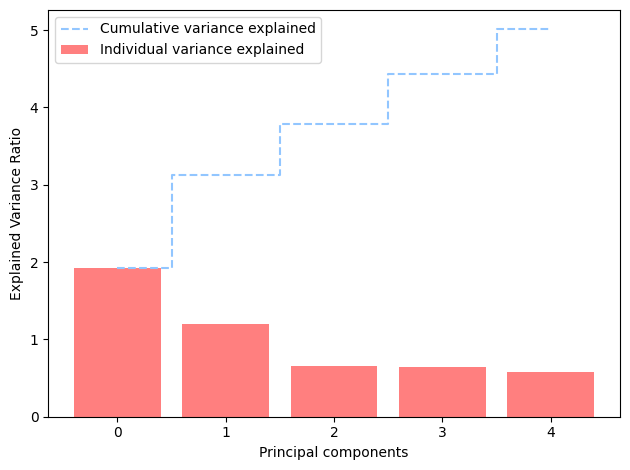

In [22]:
# Normalization to mean=0, deviation=1

X_num_std = StandardScaler().fit_transform(dataset_cleaned[X_numerical])

# Fit PCA and get new dimensional space

pca = PCA()
pca.fit(X_num_std)
X_pca = pca.transform(X_num_std)

# Analyze explained variance

ind_exp_var = pca.explained_variance_
print(f'\nIndividual variance explained: {ind_exp_var}')
cum_exp_var = np.cumsum(ind_exp_var)
print(f'\nCumulative variance explained: {cum_exp_var}')
cum_exp_rat_var = np.cumsum(pca.explained_variance_ratio_)
print(f'\nCumulative variance explained ratio: {cum_exp_rat_var}')

num_dims = X_num_std.shape[1]
with plt.style.context('seaborn-pastel'):
    plt.figure()
    plt.bar(range(num_dims), ind_exp_var, alpha=0.5, align='center', label='Individual variance explained', color='r')
    plt.step(range(num_dims), cum_exp_var, where='mid', linestyle='--', label='Cumulative variance explained')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    

Conclusions on PCA
- All components seem relevant

<h1> Prediction </h1>

In [23]:
# Get features (X) and target (y) variables
X = dataset_cleaned.drop(['price'], axis=1)
# X.drop(['parking', 'mainroad', 'guestroom', 'basement'], axis=1, inplace=True)
y = dataset_cleaned['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
# Model 1: linear regression. Train with cross-validation and evaluate

# Initialize the Linear Regression model
model1_linear = LinearRegression()

# Train the model (cross validation with 5 folds)
scoring_metrics = ['r2'] # R-squared: possible values are within [0, 1] interval; the higher (closer to 1) the better
for metric in scoring_metrics:
    # Train model for current metric
    score_results = cross_val_score(model1_linear, X_train, y_train, cv=5, scoring=metric)
    # Print model evaluation
    print(f'metric: {metric}')
    print(f'- individual scores: {score_results}')
    print(f'- mean: {score_results.mean():.3f}')
    print(f'- std dev: {score_results.std():.3f}')


metric: r2
- individual scores: [0.7068743  0.67751239 0.62533299 0.48855281 0.66480805]
- mean: 0.633
- std dev: 0.077


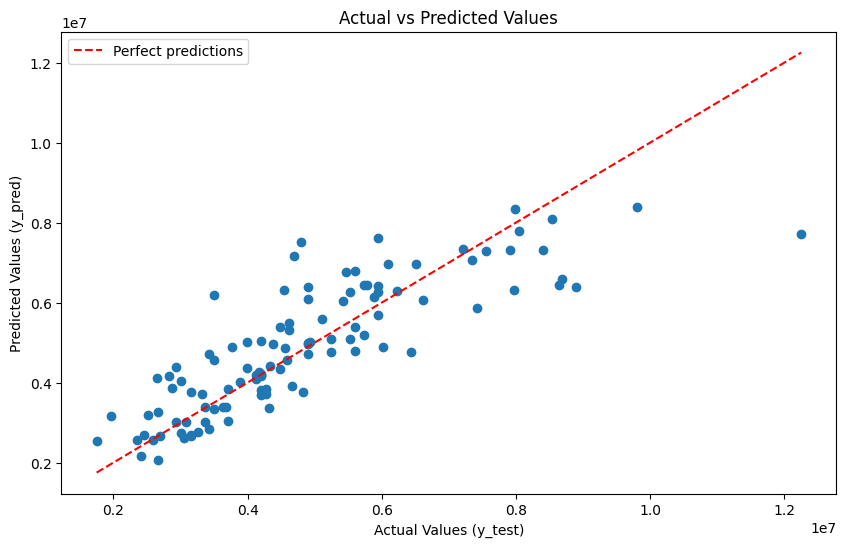

In [25]:
# Model 1: linear regression. Make some predictions

model1_linear = LinearRegression()
model1_linear.fit(X_train, y_train)
y_pred = model1_linear.predict(X_test)
df_test = X_test
df_test['price_actual'] = y_test
df_test['price_predicted'] = y_pred.astype(int)
df_test['error_over_actual'] = ((y_test - y_pred) / y_test )
df_test

# Plot y_test (actual values) vs y_predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect predictions')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()